In [1]:
%matplotlib inline

# Imports

In [2]:
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Read in / set-up data

The relevant file should have been constructed from the `start_folding_energies.ipynb` file

In [3]:
start_df = pd.read_csv('../Data/ecoli_folding_energies.tsv', sep='\t')
start_df.head()

,locus_tag,ATG_index,location,within_frame,Unconstrained_mfe,Unconstrained_ensemble,Constrained_mfe,Constrained_ensemble
0,b0001,0,External,NaN,-4.30,-2.0,-3.47,-1.4
1,b0002,0,External,NaN,-20.68,-18.1,-17.03,-14.5
2,b0002,37,Internal,False,-29.91,-27.0,-24.78,-22.7
3,b0002,79,Internal,False,-43.35,-40.8,-41.45,-39.8
4,b0002,147,Internal,True,-22.77,-20.5,-17.23,-15.8


In [4]:
#I unfortunately can't figure out an easy way to have sklearn handle categorical variables
#and they need to be hard coded to 0 or 1 instead of "Internal" or "External"

#First say that no lines are true positives (assigning them a value of zero)
start_df['True_positive'] = 0
#And now change all of the positions labeled as "External" (assigning them a value of one)
start_df.at[start_df[start_df['location']=='External'].index, 'True_positive'] = 1

In [5]:
#If I have any NaN's in my dataset, now is the time to get rid of them to prevent errors
# start_df = start_df[start_df['Constrained_mfe'].isnull() == False]

**Make an ugly plot of the difference in some relevant quantity**

Ttest_indResult(statistic=64.52095422912225, pvalue=0.0)
RanksumsResult(statistic=58.78489725726464, pvalue=0.0)


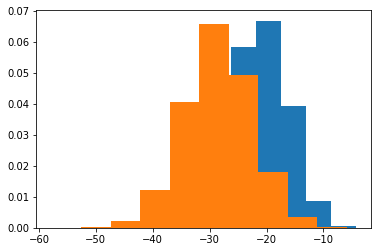

In [6]:
coi = 'Unconstrained_mfe'
a = start_df[start_df['True_positive']==1][coi]
b = start_df[start_df['True_positive']==0][coi]


fig, ax = plt.subplots()
ax.hist(a, density=True)
ax.hist(b, density=True)
print(stats.ttest_ind(a,b))
print(stats.ranksums(a,b))

**Area under the ROC**

In [64]:
coi = 'Unconstrained_mfe'
y_true = start_df['True_positive']
y_scores = start_df[coi]
print(roc_auc_score(y_true, y_scores))

0.7812592720478599


**Make a new column that compares the unconstrained to constrained values**

In [31]:
###Normalize that difference
# start_df['mfe_diff'] = (start_df['Unconstrained_mfe']-start_df['Constrained_mfe'])/start_df['Unconstrained_mfe']

###Or don't normalize it
start_df['mfe_diff'] = (start_df['Unconstrained_mfe']-start_df['Constrained_mfe'])

# Diving in to sklearn

**More data preparation**

In [67]:
#We're going to use the data (and only the data) in X to predict Y
# X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive'], axis=1)
# X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive',\
#                   'Unconstrained_ensemble', 'Constrained_ensemble', 'Unconstrained_mfe'], axis=1)
X = start_df.drop(['locus_tag', 'location', 'within_frame', 'ATG_index', 'True_positive',\
                  'Unconstrained_ensemble', 'Constrained_ensemble', 'mfe_diff'], axis=1)
Y = start_df['True_positive']

In [68]:
X.head()

,Unconstrained_mfe,Constrained_mfe
0,-4.30,-3.47
1,-20.68,-17.03
2,-29.91,-24.78
3,-43.35,-41.45
4,-22.77,-17.23


In [69]:
Y.head()

0    1
1    1
2    0
3    0
4    0
Name: True_positive, dtype: int64

**Need to separate my training and testing data**

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)

In [71]:
X_train.head()

,Unconstrained_mfe,Constrained_mfe
12869,-33.60,-19.61
45628,-32.99,-18.28
63213,-32.34,-22.29
69139,-27.03,-20.21
65709,-26.73,-21.30


In [72]:
Y_train.head()

12869    0
45628    0
63213    0
69139    0
65709    0
Name: True_positive, dtype: int64

# Fit a model to the training data

**Lots of options here. Which is best? You'd have a multi-million dollar salary at google if you could answer that definitively. Fitting may take a lot of time depending on the method**

**Initial playing around tells me that class imbalances are going to be important to consider. Which is to say, we have many more true negatives (internal not-start codons) than we do true positives (actual start codons). This will affect the ability of a model to accurately discriminate between the two without some tuning**

In [73]:
###Random forest is a good (and fast starting point). But beware class imbalances!
# from sklearn.ensemble import RandomForestClassifier
# # classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
# classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,\
#                                     class_weight='balanced')
# classifier.fit(X_train, Y_train)

# ##SVM is another VERY common option to consider. I like to have class probabilities which takes longer
# from sklearn.svm import SVC
# # classifier = SVC(kernel='rbf')
# classifier = SVC(kernel='rbf', class_weight='balanced')
# # classifier = SVC(kernel='rbf', probability=True)
# classifier.fit(X_train, Y_train)

###Good old logistic regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',\
                                class_weight='balanced')
classifier.fit(X_train, Y_train)


###Boosted trees frequently outcompete random forest classifiers but it can be tricky
# from sklearn.ensemble import GradientBoostingClassifier
# classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
# classifier.fit(X_train, Y_train)

# from sklearn.gaussian_process import GaussianProcessClassifier
# classifier = GaussianProcessClassifier(random_state=0)
# classifier.fit(X_train, Y_train)

# from sklearn.neural_network import MLPClassifier
# classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

# Evaluate how we did

(I need to check into what the `classifier.score` is and whether we can change it).

But the important thing is that ideally there isn't a *huge* dropoff between score on the training and testing data (this would happen if we overfit to the training data). But a drop is natural to see.

In [74]:
classifier.score(X_train, Y_train), classifier.score(X_test, Y_test)

(0.7105131313131313, 0.7112935548516388)

**Look at the confusion matrix and classification reports**

In [75]:
test_pred = classifier.predict(X_test)
print(confusion_matrix(Y_test, test_pred))
print(classification_report(Y_test,test_pred))

[[10467  4246]
 [  220   536]]
             precision    recall  f1-score   support

          0       0.98      0.71      0.82     14713
          1       0.11      0.71      0.19       756

avg / total       0.94      0.71      0.79     15469



**To get an ROC score you need to convert from binary classification (yes/no) to a probability of being yes or no. With those probabilites, we can run an ROC test. Note: some fitting methods used above will not output a probability score or do so by default**

In [76]:
test_prob = classifier.predict_proba(X_test)
a, b = zip(*test_prob)
test_prob = b
print(roc_auc_score(Y_test, test_prob))

0.7749595254098075


**Some methods let you look at how important different features are/were**

In [77]:
classifier.feature_importances_

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [78]:
classifier.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [79]:
classifier.coef_

array([[ 0.10829117, -0.02125063]])